# Chatbot
* Make the chatbot so that you classify a category (i.e., tag) of input text
    * Return a dialog from the correct class
    * Note that one question could have multiple tags and you may need to simplify
* Alternatively, make a sequence to sequence network that automatically learns what to respond
    * It can be character based or word based
* Hint:  Start with a subset of the dataset
---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from nltk.stem import *

import re
import random
np.random.seed(7)

## Load into dataframes

In [2]:
questions_df = pd.read_csv("./archive/Questions.csv")
answers_df = pd.read_csv("./archive/Answers.csv")
tags_df = pd.read_csv("./archive/Tags.csv")

In [3]:
questions_df.head(15)
#questions_df.describe()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...
5,742,189.0,2008-08-03T15:55:28Z,30,Class views in Django,"<p><a href=""http://www.djangoproject.com/"">Dja..."
6,766,1384652.0,2008-08-03T17:44:07Z,20,Python and MySQL,<p>I can get Python to work with Postgresql bu...
7,773,207.0,2008-08-03T18:27:09Z,256,How do I use Python's itertools.groupby()?,<p>I haven't been able to find an understandab...
8,972,145.0,2008-08-04T02:17:51Z,364,Adding a Method to an Existing Object Instance,<p>I've read that it is possible to add a meth...
9,1476,92.0,2008-08-04T18:20:36Z,251,How do you express binary literals in Python?,<p>How do you express an integer as a binary n...


In [4]:
answers_df.head(15)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."
5,595,116.0,2008-08-03T01:17:36Z,594,25,<p>The canonical way is to use the built-in cu...
6,660,197.0,2008-08-03T12:09:18Z,535,14,<p>Second the Buildbot - Trac integration. You...
7,701,111.0,2008-08-03T14:30:50Z,683,3,"<p>No, you were not dreaming. Python has a pr..."
8,735,145.0,2008-08-03T15:47:22Z,683,-2,<p>I think:</p>\n\n<pre><code>#!/bin/python<br...
9,745,154.0,2008-08-03T15:59:19Z,683,8,<p>Are you looking to get a list of objects th...


In [5]:
tags_df.dropna(inplace=True)
tags_df.head(15)
#tags_df.nunique()
#tags_df.count()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python
5,502,windows
6,502,image
7,502,pdf
8,535,python
9,535,continuous-integration


In [6]:
print("Questions:\t", len(questions_df))
print("Answers:\t", len(answers_df))
print("Tags:\t\t", len(tags_df))
print("\nThese must be the same size!")

Questions:	 607282
Answers:	 987122
Tags:		 1884635

These must be the same size!


---
## Assumptions and decisions
* Drop questions without answers
* Only keep the top answer (the one with the most votes)
* As all questions are related to python, `python` is not a relevant tag
    * Drop all tags with `Tag='python'`
    * Only keep the first tag per `Id` for easier classification
* **The question, answer, and tag lists must have the same size**
    * All questions must have an answer and a tag
    * One answer per question
    * One tag per question

In [7]:
# Drop questions without answers
questions_with_answer = questions_df[questions_df['Id'].isin(answers_df['ParentId'])]
print("Questions with answers:", len(questions_with_answer))

Questions with answers: 539238


In [8]:
# Drop all python tags
no_python_tags = tags_df[tags_df['Tag'] != 'python']

# Only keep the first tag per question (if several)
no_dup_tags = no_python_tags.drop_duplicates(subset='Id')

# As we have dropped questions, we also need to drop the corresponding tags
tags_with_questions = no_dup_tags[no_dup_tags['Id'].isin(questions_with_answer['Id'])]
print("Tags with questions:", len(tags_with_questions))

Tags with questions: 498305


In [9]:
# Drop the questions that no longer have tags
questions_with_tag = questions_with_answer[questions_with_answer['Id'].isin(tags_with_questions['Id'])]
print("Questions with answers and tags:", len(questions_with_tag))

Questions with answers and tags: 498305


In [10]:
# Drop answers that no longer have questions
answers_with_questions = answers_df[answers_df['ParentId'].isin(questions_with_tag['Id'])]

# Keep the answer with the highest score, sort them by question ID
grouped_answers = answers_with_questions.sort_values(['Score'], ascending=False).groupby('ParentId').head(1)
sorted_answers = grouped_answers.sort_values(['ParentId'])
print("Top answers: ", len(sorted_answers))

Top answers:  498305


In [11]:
print("Questions:\t", len(questions_with_tag))
print("Answers:\t", len(sorted_answers))
print("Tags:\t\t", len(tags_with_questions))

if len(questions_with_tag) == len(sorted_answers) and len(questions_with_tag) == len(tags_with_questions):
    print("\nAll are now the same size!")
else:
    print("\nRecalculate!")

Questions:	 498305
Answers:	 498305
Tags:		 498305

All are now the same size!


In [12]:
df_questions = questions_with_tag.reset_index(drop=True)
df_answers = sorted_answers.reset_index(drop=True)
df_tags = tags_with_questions.reset_index(drop=True)
num_questions = len(df_questions)

In [13]:
def detect_indexing_errors():
    detected_errors = False
    for i in trange(num_questions):
        q_id = df_questions.loc[i]['Id']
        a_id = df_answers.loc[i]['ParentId']
        t_id = df_tags.loc[i]['Id']
        is_same = q_id == a_id and q_id == t_id
        if not is_same:
            detected_errors = True
            print(f"Q: {q_id}, A: {a_id}, T: {t_id}")
            break
    return detected_errors

**NB! This takes a while, do not run unless necessary**

In [14]:
detected_errors = detect_indexing_errors()
can_proceed = "Yes" if not detected_errors else "NO"
print("Can proceed:", can_proceed)


Can proceed: Yes


## Preprocessing text
* Questions is x (ID is index)
    * Only use the title of the question, as I assume this is the most similar to what will be asked in a chatbot
* Tags is y (ID is index)
* Answers are given as response in the chatbot
* **Testing with a dataset of 1000 entries first**

In [16]:
train_size = 1000

In [17]:
x_train_temp = df_questions['Title'].to_numpy()[:train_size]
y_train_temp = df_tags['Tag'].to_numpy()[:train_size].tolist()
html_answers = df_answers['Body'].to_numpy()[:train_size].tolist()

In [19]:
print(x_train_temp[:20])

['How can I find the full path to a font from its display name on a Mac?'
 'Get a preview JPEG of a PDF on Windows?'
 'Continuous Integration System for a Python Codebase'
 'cx_Oracle: How do I iterate over a result set?'
 "Using 'in' to match an attribute of Python objects in an array"
 'Class views in Django' 'Python and MySQL'
 "How do I use Python's itertools.groupby()?"
 'Adding a Method to an Existing Object Instance'
 'How do you express binary literals in Python?'
 'Any experiences with Protocol Buffers?'
 'Python: what is the difference between (1,2,3) and [1,2,3], and when should I use each?'
 'File size differences after copying a file to a server vía FTP'
 'How can I create a directly-executable cross-platform GUI app using Python?'
 'Programmatically talking to a Serial Port in OS X or Linux'
 'How to sell Python to a client/boss/person with lots of cash'
 'How do you set up Python scripts to work in Apache 2.0?'
 'Does anyone have experience creating a shared library in M

In [20]:
print(y_train_temp[:100])

['osx', 'windows', 'continuous-integration', 'sql', 'arrays', 'django', 'mysql', 'iteration', 'oop', 'syntax', 'xml', 'list', 'php', 'user-interface', 'linux', 'php', 'apache', 'c', 'user-interface', 'floating-point', 'unicode', 'urllib', 'data-structures', 'mysql', 'xml', 'mp3', 'c++', 'xml', 'doctest', '.net', 'string', 'regex', 'functional-programming', 'osx', 'regex', 'regex', 'xml', 'swig', 'xss', 'zip', 'command-line', 'validation', 'object', 'list', 'php', 'command-line', 'linux', 'database', 'mysql', 'java', 'datetime', 'ruby', 'django', 'string-formatting', 'windows', 'ruby', 'visual-studio-2008', 'windows', 'binary', 'gtk', 'reflection', 'user-interface', 'translation', 'php', 'security', 'c', 'linux', 'refactoring', 'web-services', 'xml', 'linux', 'osx', 'multithreading', 'django', 'file-io', 'windows', 'unit-testing', 'ssh', 'performance', 'multithreading', 'http', 'django', 'language-features', 'windows', 'introspection', 'pylons', 'html', 'mapping', 'ruby', 'ide', 'shell'

In [21]:
def clean_html(raw_html):
    cleanr = re.compile("<.*?>")
    clean_text = re.sub(cleanr, "", raw_html)
    return clean_text

In [27]:
# Remove all html tags from answers
answers = [clean_html(ans) for ans in html_answers]

print("EXAMPLE:")
print(f"\"{html_answers[0]}\"")
print("\nTURNS INTO:")
print(f"\"{answers[0]}\"")

EXAMPLE:
"<p>Unfortunately the only API that isn't deprecated is located in the ApplicationServices framework, which doesn't have a bridge support file, and thus isn't available in the bridge. If you're wanting to use ctypes, you can use ATSFontGetFileReference after looking up the ATSFontRef.</p>

<p>Cocoa doesn't have any native support, at least as of 10.5, for getting the location of a font.</p>"

TURNS INTO:
"Unfortunately the only API that isn't deprecated is located in the ApplicationServices framework, which doesn't have a bridge support file, and thus isn't available in the bridge. If you're wanting to use ctypes, you can use ATSFontGetFileReference after looking up the ATSFontRef.

Cocoa doesn't have any native support, at least as of 10.5, for getting the location of a font."


### Getting categories

In [28]:
categories = list(set(y_train_temp))
print(len(categories))

324


In [29]:
# Replace each label with its category index (both x and y here are now numpy arrays)
y_train_org = np.array([categories.index(i) for i in y_train_temp])
x_train_org = x_train_temp[:]

num_classes = len(categories)
y_train = []

In [30]:
for n in [categories.index(i) for i in y_train_temp]:
    y_train.append([0 for i in range(num_classes)]) # Create an array of 324 zeros (category set length)
    y_train[-1][n] = 1 # Set the index to 1 for the label in mention

### Embedding and stemming

In [31]:
all_words = " ".join(x_train_temp).lower().split(" ")
unique_words = list(set(all_words))

stemmer = PorterStemmer()
# TODO: Actually do some stemming

x_train = []
x_array_size = 10

**Make text into numbers:**
* Takes each line and returns an array of ten numbers
* If ten or more words, append the appropriate `unique_words` index
* If less than ten words, simply add zeros so the array is always of length 10

Example:  
"*Continuous Integration System for a Python Codebase*" → `[1271, 24, 1360, 375, 588, 294, 1789, 0, 0, 0]`

In [32]:
def make_text_into_numbers(text):
    iwords = text.lower().split(" ")
    numbers = []
    
    for n in iwords:
        try:
            numbers.append(unique_words.index(n))
        except ValueError:
            numbers.append(0)
    
    zeros_array = np.zeros(x_array_size - 1).tolist()
    numbers = numbers + zeros_array # add zeros in case of less than required array size
    return numbers[:x_array_size]

In [33]:
for i in x_train_temp:
    t = make_text_into_numbers(i)
    x_train.append(t)

In [34]:
# Assure that each array in x_train is of intended array size
print(set([len(i) for i in x_train]))

{10}


In [35]:
x_train = torch.LongTensor(x_train)
y_train = torch.Tensor(y_train)

In [36]:
print(x_train)
print(y_train)

tensor([[ 764, 2021, 1375,  ...,  826,   54,  828],
        [ 304,   54,   56,  ...,    4, 1308,    0],
        [ 790,   15, 2236,  ...,    0,    0,    0],
        ...,
        [ 702, 1601, 1977,  ...,    0,    0,    0],
        [ 764,  826, 2323,  ...,    4,  109,  157],
        [ 775, 1283, 2323,  ...,  873, 1599,    0]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


---
## Model

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(len(unique_words), 128)
        
        self.lstm = nn.LSTM(input_size = 128,
                           hidden_size = 128,
                           num_layers = 1,
                           batch_first = True,
                           bidirectional = False)
        
        self.fc1 = nn.Linear(128, 512)
        # TODO: A middle layer here?
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, inp):
        e = self.embedding(inp)
        output, hidden = self.lstm(e)
        
        x = self.fc1(output[:, -1, :])
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [40]:
net = Net()
print("Model", net)
print("Parameters", [param.nelement() for param in net.parameters()])

Model Net(
  (embedding): Embedding(2400, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=324, bias=True)
)
Parameters [307200, 65536, 65536, 512, 512, 65536, 512, 165888, 324]


In [41]:
max_words = 10
batch_size = 1
epochs = 5
learning_rate = 0.001

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [43]:
t_loss = []
v_loss = []

t_acc = []
v_acc = []

In [44]:
def avg(l):
    return sum(l) / len(l)

## Train model

In [45]:
n_steps = 1000

for i in trange(n_steps):
    y_pred_train = net(x_train)
    loss_train = loss_fn(y_pred_train, y_train)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    loss = loss_train.detach().numpy()
    t_loss.append(loss)
    
    # Print loss each 100th round
    if i%100 == 0:
        print(loss)

0.25102994
0.2509648
0.25089985
0.25083512
0.25077027
0.2507055
0.25064093
0.25057635
0.25051168
0.2504473



### Plot loss

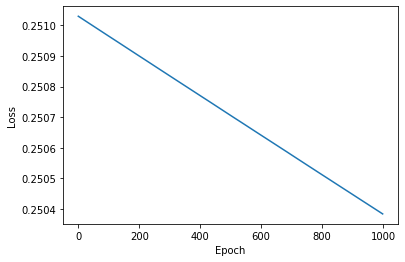

In [46]:
x_values = [i for i in range(n_steps)]

plt.plot(x_values, t_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Test model

In [47]:
def classify(user_input):
    indices = make_text_into_numbers(user_input)
    question_tensor = torch.LongTensor([indices])
    output = net(question_tensor).detach().numpy()
    tag_index = np.argmax(output)
    return tag_index

In [48]:
print("Chatbot: What can I help you with today?")

user_input = input("You: ")
while user_input != "Bye":
    tag_index = classify(user_input)
    answer = answers[tag_index]
    print(f"Chatbot: {answer}")
    user_input = input("Question: ")

print("Chatbot: Have a nice day! Beep boop")

Chatbot: What can I help you with today?
You: Change path files for osx
Chatbot: There's a text progress bar library for python at  http://pypi.python.org/pypi/progressbar/2.2 that you might find useful: 


  This library provides a text mode progressbar. This is tipically used to display the progress of a long running operation, providing a visual clue that processing is underway.
  
  The ProgressBar class manages the progress, and the format of the line is given by a number of widgets. A widget is an object that may display diferently depending on the state of the progress. There are three types of widget: - a string, which always shows itself; - a ProgressBarWidget, which may return a diferent value every time it's update method is called; and - a ProgressBarWidgetHFill, which is like ProgressBarWidget, except it expands to fill the remaining width of the line.
  
  The progressbar module is very easy to use, yet very powerful. And automatically supports features like auto-resizing